In [1]:
import gym


# 定义环境
class MyWrapper(gym.Wrapper):
    def __init__(self):
        env = gym.make('Pendulum-v1', render_mode='rgb_array')
        super().__init__(env)
        self.env = env
        self.step_n = 0

    def reset(self):
        state, _ = self.env.reset()
        self.step_n = 0
        return state

    def step(self, action):
        state, reward, terminated, truncated, info = self.env.step(action)
        self.step_n += 1
        done = True if self.step_n >= 200 else terminated or truncated
        return state, reward, done, info


env = MyWrapper()

env.reset()

array([-0.8785941 ,  0.47756928, -0.72139657], dtype=float32)

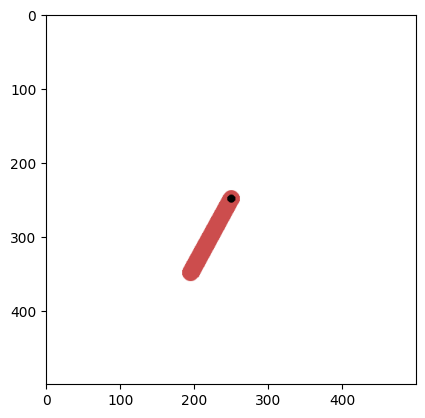

In [2]:
from matplotlib import pyplot as plt


# 打印游戏
def show():
    plt.imshow(env.render())
    plt.show()


show()

In [3]:
import torch

# 计算动作的模型,也是真正要用的模型
model = torch.nn.Sequential(
    torch.nn.Linear(3, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 11),
)

# 经验网络,用于评估一个状态的分数
next_model = torch.nn.Sequential(
    torch.nn.Linear(3, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 11),
)

# 把model的参数复制给next_model
next_model.load_state_dict(model.state_dict())

model, next_model

(Sequential(
   (0): Linear(in_features=3, out_features=128, bias=True)
   (1): ReLU()
   (2): Linear(in_features=128, out_features=11, bias=True)
 ),
 Sequential(
   (0): Linear(in_features=3, out_features=128, bias=True)
   (1): ReLU()
   (2): Linear(in_features=128, out_features=11, bias=True)
 ))

In [4]:
import random


def get_action(state):
    # 走神经网络,得到一个动作
    state = torch.FloatTensor(state).reshape(1, 3)
    action = model(state).argmax().item()

    if random.random() < 0.01:
        action = random.choice(range(11))

    # 离散动作连续化
    action_continuous = action
    action_continuous /= 10
    action_continuous *= 4
    action_continuous -= 2

    return action, action_continuous


get_action([0.29292667, 0.9561349, 1.0957013])

(4, -0.3999999999999999)

In [5]:
# 样本池
datas = []


# 向样本池中添加N条数据,删除M条最古老的数据
def update_data():
    old_count = len(datas)

    # 玩到新增了N个数据为止
    while len(datas) - old_count < 200:
        # 初始化游戏
        state = env.reset()

        # 玩到游戏结束为止
        over = False
        while not over:
            # 根据当前状态得到一个动作
            action, action_continuous = get_action(state)

            # 执行动作,得到反馈
            next_state, reward, over, _ = env.step([action_continuous])

            # 记录数据样本
            datas.append((state, action, reward, next_state, over))

            # 更新游戏状态,开始下一个动作
            state = next_state

    update_count = len(datas) - old_count
    drop_count = max(len(datas) - 5000, 0)

    # 数据上限,超出时从最古老的开始删除
    while len(datas) > 5000:
        datas.pop(0)

    return update_count, drop_count


update_data(), len(datas)

((200, 0), 200)

In [6]:
# 获取一批数据样本
def get_sample():
    # 从样本池中采样
    samples = random.sample(datas, 64)

    # [b, 3]
    state = torch.FloatTensor([i[0] for i in samples]).reshape(-1, 3)
    # [b, 1]
    action = torch.LongTensor([i[1] for i in samples]).reshape(-1, 1)
    # [b, 1]
    reward = torch.FloatTensor([i[2] for i in samples]).reshape(-1, 1)
    # [b, 3]
    next_state = torch.FloatTensor([i[3] for i in samples]).reshape(-1, 3)
    # [b, 1]
    over = torch.LongTensor([i[4] for i in samples]).reshape(-1, 1)

    return state, action, reward, next_state, over


state, action, reward, next_state, over = get_sample()

state, action, reward, next_state, over

C:\Users\25338\AppData\Local\Temp\ipykernel_12092\3739385932.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:248.)
  state = torch.FloatTensor([i[0] for i in samples]).reshape(-1, 3)


(tensor([[-0.8964,  0.4433,  4.4351],
         [-0.5808, -0.8141, -4.0892],
         [-0.9552, -0.2961,  5.0671],
         [-0.5572,  0.8304,  1.1374],
         [ 0.0818, -0.9966,  2.3502],
         [-0.9214, -0.3887, -5.0016],
         [-0.8684,  0.4958, -3.7820],
         [-0.5639, -0.8259, -3.7173],
         [-0.8527,  0.5225,  3.9092],
         [-0.8775, -0.4795, -4.5906],
         [ 0.3684, -0.9297,  1.4943],
         [-0.1863, -0.9825,  3.2286],
         [-0.7201, -0.6939, -4.0967],
         [-0.6007, -0.7995,  4.7565],
         [-0.6178,  0.7864, -2.7987],
         [-0.8453,  0.5343,  3.5031],
         [-0.5302,  0.8479, -1.9138],
         [-0.7769,  0.6296,  3.7829],
         [-0.8287, -0.5597,  4.8279],
         [-0.4437, -0.8962, -4.0138],
         [ 0.2426, -0.9701, -0.0375],
         [-0.4632,  0.8862, -1.6645],
         [-0.6611, -0.7503,  5.1291],
         [-0.9947, -0.1032,  4.9191],
         [-0.6797, -0.7335,  4.5881],
         [ 0.1709, -0.9853,  2.1486],
         [-0

In [7]:
def get_value(state, action):
    # 使用状态计算出动作的logits
    # [b, 3] -> [b, 11]
    value = model(state)

    # 根据实际使用的action取出每一个值
    # 这个值就是模型评估的在该状态下,执行动作的分数
    # 在执行动作前,显然并不知道会得到的反馈和next_state
    # 所以这里不能也不需要考虑next_state和reward
    # [b, 11] -> [b, 1]
    value = value.gather(dim=1, index=action)

    return value


get_value(state, action)

tensor([[0.6669],
        [0.6767],
        [0.9877],
        [0.3187],
        [0.8581],
        [0.7858],
        [0.7064],
        [0.6234],
        [0.5514],
        [0.7329],
        [0.7292],
        [0.9917],
        [0.6684],
        [1.1579],
        [0.6367],
        [0.4667],
        [0.5549],
        [0.5158],
        [1.0436],
        [0.6730],
        [0.4895],
        [0.5389],
        [1.2070],
        [0.8893],
        [1.0837],
        [0.8268],
        [0.6260],
        [0.6889],
        [0.6029],
        [0.4612],
        [0.2550],
        [0.4985],
        [0.3415],
        [0.3208],
        [0.4101],
        [0.3546],
        [1.1286],
        [0.7336],
        [0.7267],
        [0.7238],
        [0.9433],
        [0.7503],
        [0.7505],
        [0.7268],
        [0.3991],
        [0.4703],
        [0.6915],
        [1.1891],
        [0.9340],
        [1.0187],
        [1.0604],
        [0.3180],
        [0.3984],
        [0.8247],
        [0.3084],
        [0

In [8]:
def get_target(reward, next_state, over):
    # 上面已经把模型认为的状态下执行动作的分数给评估出来了
    # 下面使用next_state和reward计算真实的分数
    # 针对一个状态,它到底应该多少分,可以使用以往模型积累的经验评估
    # 这也是没办法的办法,因为显然没有精确解,这里使用延迟更新的next_model评估

    # 使用next_state计算下一个状态的分数
    # [b, 3] -> [b, 11]
    with torch.no_grad():
        target = next_model(next_state)
    """以下是主要的Double DQN和DQN的区别"""
    # 取所有动作中分数最大的
    # [b, 11] -> [b]
    # target = target.max(dim=1)[0]

    # 使用model计算下一个状态的分数
    # [b, 3] -> [b, 11]
    with torch.no_grad():
        model_target = model(next_state)

    # 取分数最高的下标
    # [b, 11] -> [b, 1]
    model_target = model_target.max(dim=1)[1]
    model_target = model_target.reshape(-1, 1)

    # 以这个下标取next_value当中的值
    # [b, 11] -> [b]
    target = target.gather(dim=1, index=model_target)
    """以上是主要的Double DQN和DQN的区别"""

    # 下一个状态的分数乘以一个系数,相当于权重
    target *= 0.98

    # 如果next_state已经游戏结束,则next_state的分数是0
    # 因为如果下一步已经游戏结束,显然不需要再继续玩下去,也就不需要考虑next_state了.
    # [b, 1] * [b, 1] -> [b, 1]
    target *= 1 - over

    # 加上reward就是最终的分数
    # [b, 1] + [b, 1] -> [b, 1]
    target += reward

    return target


get_target(reward, next_state, over)

tensor([[ -8.3690],
        [ -5.7666],
        [ -9.5925],
        [ -4.5141],
        [ -2.0328],
        [ -9.2579],
        [ -7.6431],
        [ -5.4378],
        [ -7.5669],
        [ -8.3608],
        [ -1.0079],
        [ -3.2430],
        [ -6.6308],
        [ -6.0433],
        [ -5.2321],
        [ -7.2774],
        [ -4.3977],
        [ -6.8331],
        [ -7.7605],
        [ -5.0259],
        [ -1.3866],
        [ -4.0012],
        [ -6.6986],
        [-10.6752],
        [ -6.4172],
        [ -1.7040],
        [ -8.6623],
        [ -6.0271],
        [ -4.5858],
        [ -1.5661],
        [ -1.7770],
        [ -1.1614],
        [ -3.9042],
        [ -6.1115],
        [ -1.0578],
        [ -2.1171],
        [ -5.4282],
        [ -7.3900],
        [ -9.9057],
        [ -7.1501],
        [ -2.1990],
        [-10.9414],
        [ -8.2333],
        [-10.2221],
        [ -3.2473],
        [ -2.9006],
        [-10.3167],
        [ -4.1089],
        [ -1.7376],
        [ -3.1803],


In [9]:
from IPython import display


def test(play):
    # 初始化游戏
    state = env.reset()

    # 记录反馈值的和,这个值越大越好
    reward_sum = 0

    # 玩到游戏结束为止
    over = False
    while not over:
        # 根据当前状态得到一个动作
        _, action_continuous = get_action(state)

        # 执行动作,得到反馈
        state, reward, over, _ = env.step([action_continuous])
        reward_sum += reward

        # 打印动画
        if play and random.random() < 0.2:  # 跳帧
            display.clear_output(wait=True)
            show()

    return reward_sum


test(play=False)

-1591.5472888495935

In [10]:
def train():
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    loss_fn = torch.nn.MSELoss()

    # 训练N次
    for epoch in range(200):
        # 更新N条数据
        update_count, drop_count = update_data()

        # 每次更新过数据后,学习N次
        for i in range(200):
            # 采样一批数据
            state, action, reward, next_state, over = get_sample()

            # 计算一批样本的value和target
            value = get_value(state, action)
            target = get_target(reward, next_state, over)

            # 更新参数
            loss = loss_fn(value, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # 把model的参数复制给next_model
            if (i + 1) % 50 == 0:
                next_model.load_state_dict(model.state_dict())

        if epoch % 20 == 0:
            test_result = sum(test(play=False) for _ in range(20)) / 20
            print(epoch, len(datas), update_count, drop_count, test_result)


train()

0 400 200 0 -1601.628313464433
20 4400 200 0 -1475.8052638706663
40 5000 200 200 -1114.7143949048668
60 5000 200 200 -1002.7232591906319
80 5000 200 200 -589.6962169225968
100 5000 200 200 -347.07441858565875
120 5000 200 200 -270.5948025004217
140 5000 200 200 -554.0882353850703
160 5000 200 200 -207.96896090556737
180 5000 200 200 -411.5884678289837


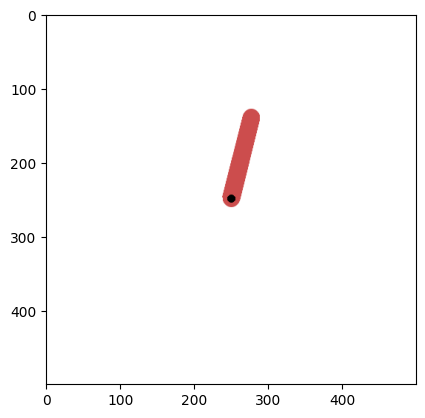

-257.6738450033536

In [11]:
test(play=True)